## TorchTS ODE Solver

Implements a neural network solving system of first-order ordinary differential equations (ODEs) where the independent  variable is time $t$, and finds coefficients in ODEs which minimize misfit to the data.
The solver is based on code by 
[Wang et al. (2021)](http://proceedings.mlr.press/v144/wang21a.html)

The ODE system is denoted as 

\begin{equation*}
    \frac{d \mathbf{A}}{d t} = \mathbf{F}(a_n)
\end{equation*}

or in uncollapsed form

\begin{align*}
\frac{d a_1}{d t} =& f_1(a_1, a_2, \dots a_n) \\
\frac{d a_2}{d t} =& f_2(a_1, a_2, \dots a_n) \\
\vdots \\
\frac{d a_n}{d t} =& f_n(a_1, a_2, \dots a_n) \\
\end{align*}

An example of such a system (which was used to develop the solver) is the 
[SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model) 
model for epidemic disease modeling: 
<br>
\begin{align}
\frac{d S_t}{dt} &= - \frac{\beta_t I_t S_t}{N}, \\
\frac{d E_t}{dt} &= \frac{\beta_t I_t S_t}{N} - \sigma_t E_t \\
\frac{d I_t}{dt} &= \sigma_t E_t - \gamma_t I_t \\
\frac{d R_t}{dt} &= \gamma_t I_t
\end{align}

Here, the the compartment $S$ (susceptible population) represents the first variable $a_1$, and $f_1$ is denoted by the right-hand-side of the top equation.
The coefficients $\beta$, $\sigma$ and $\gamma$ (either constant or time-dependent, still to be implemented) are optimized using PyTorch.

In order to solve various different systems of ODEs, the following quantities must be somehow parameterized and passed to the solver:
- The equations $f_n$. 
- The coefficients (and a flag denoting whether they are time-dependent)
- The data used to train the model. 
- An optional output modifier which takes the numerical solution and brings it into a shape consistent with the training data such that the loss can be calculated, as explained below.
- Other user-controllable parameters including the temporal discretization (time step),
optimizer, scheduler learning rate and loss function.

### Specification of the variables, parameters and functions

Variables, ODEs and initial values for coefficients are passed to the function during initialization:

    ODESolver(inivals, cfuncs, inicoeffs, dt, time-dependent=False, 
        solver='Euler', outvar=None)

##### Variables
For working with the solver it's easier and more intuitive to assign actual variable names to each quantity.
They are provided as the keys in the dictionary passed to 
the positional argument `inivals`.   The values of the dictionary provide the initial values assigned to each quantity.
For the SEIR model, one could use, for example:

    inivals = {"S": 0.95, "E": 0.,"I" 0.05 : ,"R": 0}
    
(Here, the population in each compartments is normalized by the total population size).

##### Functions

A function specifying the right-hand term in each of the system of ODE's is passed to the solver as a dictionary in the
positional argument `cfuncs`.  The equation pertaining to each variable is stored under the key representing the respective variable.
Each function receives two positional arguments, `cvars` and `coeffs`.  These will be dictionaries containing the 
system's current variables and coefficients.  As an example, the function describing the ODE for quantity $S$ would be defined as:

    def fS(cvar, coeffs):
        return (-coeffs["beta"] * cvar["I"] * cvar["S"])

##### Inicoeffs

Initial values for the coefficients are provided in the dictionary inicoeffs.  Each coefficient must be present,
and the keys in the dictionary passed to the solver must represent the names of the coefficients that will be optimized through data.

In the SEIR example, one could use
    
    inicoeffs={"beta": 0.50, "gamma": 0.20, "sigma": 0.20}

#####  Output quantities (and time skip, still ToDo):

By default, the network returns a time-dependent value for every variable and every discrete time step resolved 
during numerical integration.  Depending on the model and data, a training value may not be available for quantity.
For example, only data on the currently infected and susceptible population was typically be available during the Covid-19 pandemic, but not on the exposed population.
(Alternatively, one might only have data on cumulative reported cases (`cumsum(I)`), not currently infectious cases.
Handling such cases will require functionaly that is not yet implemented.)

The keyword variable `outvar` designates the names of the output quantities that are present in the data and used 
for computation of the loss.  In addition, it indicates the order in which they are present in the training dataset
(format described below).
By default, `outvar` is the same as `variables`.  In the case of the compartmental model, one would use
`outvar = ["S","I","R"]`, as no data on the exposed population $E$ is available.

### Training the network

The solver is trained using 

    ODESolver.fit(train_data,  num_epochs=100,  lr=0.001, optimizer= None, 
        scheduler = None, loss_fun=torch.nn.MSELoss()):

The PyTorch tensor `train_data` is assumed to be of the shape `(nt,nvar)`, where `nt` is the number of time steps used for training and `nvar` is the number of output variables (consistent with `len(outvar)`).  The sampling interval of the data is expected to be the same as the timestep `dt` passed to the solver during initialization.

By default, the value `None` is passed for the optimizer and scheduler, 
and the network uses 

    optimizer = torch.optim.Adam(self.coeffs.values(), 0.001)        
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
  
To learning rate can be changed using the keyword argument `lr`.  If a custom optimizer is provided,
the optimizer's coded learning rate is used.  A warning is issued if the user tries to set both.

### Predicting

Predictions are made using 

    ODESolver.predict(nt)
   
Where `nt` represents the total number of time steps in the prediction (starting from the same origin time as used in the training data).

In [127]:
import torch
import numpy as np
import torch.nn as nn
from scipy.integrate import odeint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"
#device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt

from tqdm import tqdm

cuda


In [128]:
class ODESolver(nn.Module):
    def __init__(self, inivals, cfuncs, inicoeffs, dt, time_dependent=False, solver='Euler', outvar=None):
        super(ODESolver, self).__init__()
        
        self.cnames=inivals.keys()
        self.cfuncs=cfuncs
        
        assert inivals.keys() == cfuncs.keys(), "inconsistent keys in inivals and cfuncs"
        
        #self.initial = inicoeffs
        
        self.initial = {}
        for var in self.cnames:
            self.initial[var] = torch.nn.Parameter(torch.tensor(inivals[var]))
            
        self.coeffs={}
        
        assert time_dependent == False, "time-dependent coefficients not yet implemented"
        
        for coeff in inicoeffs.keys():
            #if not time_dependent:
                self.coeffs[coeff] = torch.nn.Parameter(torch.tensor(inicoeffs[coeff]))
            #else:
            #    self.coeffs[coeff] = torch.nn.Parameter(torch.ones(nt)*inicoeffs[coeff])

        self.dt = torch.tensor(dt)
        
        assert solver == "Euler", "%s solver not (yet) implemented" % solver
        self.solver = solver
        
        if type(outvar) == type(None):
            self.outvar = self.cnames
        else:
            self.outvar = outvar
        
        #predicted values of the variables
        self.P={}
        
    def Euler(self, nt):
        for var in self.cnames:
            self.P[var] = [self.initial[var].reshape(-1,1)]

        for n in range(nt-1):
            #create dictionary containing only value from previous time step
            cvar={var: self.P[var][n] for var in self.cnames}
            for var in self.cnames:
                self.P[var].append( 
                    (self.P[var][n] + self.cfuncs[var](cvar, self.coeffs) * self.dt).reshape(-1,1)
                )

        #reformat output to contain only needed (observed) variables:
        y_pred = torch.cat([torch.cat(self.P[var], dim = 0) for var in self.outvar], dim=1)

        return y_pred
            
    def forward(self, nt):
        if self.solver == "Euler":
            return self.Euler(nt)
        elif self.solver == "RK4":
            return self.RK4(nt)
        else:
            print("Error. Solver %s not implemented." % self.solver)        
            
    def fit(self, train_data, num_epochs=100, lr=None,
            optimizer = None,
            scheduler = None,
            loss_fun=torch.nn.MSELoss()):
        
        nt=train_data.shape[0]
        noutvar=train_data.shape[1]
        
        assert noutvar == len(self.outvar), "Number of training variables inconsistent with output variables"
        
        if type(lr) != type(None) and type(optimizer) != type(None):
            if optimizer.defaults["lr"] != lr:
                print("Warning: Learning rate %f specified as keyword argument" % lr)
                print("         but %f is used in provided optimizer" % optimizer.defaults["lr"]) 
                print("         The latter takes precedence.")
            
        if type(lr) == type(None):
            lr=0.001
            
        if type(optimizer) == type(None):
            optimizer=torch.optim.Adam(self.coeffs.values(), lr)
            
        if type(scheduler) == type(None):
            scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
            
        y_approx = self(nt)
        initial_loss = loss_fun(y_approx, training_data)
        
        from tqdm import tqdm
        tqdm_epochs = tqdm(range(num_epochs))
            
        min_loss = 10

        for e in tqdm_epochs:
            y_approx = self(nt)
            loss = loss_fun(y_approx, training_data)
            if loss.item() < min_loss:
                best_model = self
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})
    def get_coeffs(self):
        return {coeff: self.coeffs[coeff].item() for coeff in self.coeffs}
    
    def predict(self, nt):
        y_predict=self(nt)
        return y_predict

Defining all the functions.  Here, the coefficient $\beta$ is assumed to be normalized by the total population $N$ already.  Population sizes are assumed normalized by the total population as well.

In [129]:
def fS(cvar, coeffs):
    return -coeffs["beta"] * cvar["I"] * cvar["S"]

def fE(cvar, coeffs):
    return coeffs["beta"] * cvar["I"] * cvar["S"] - coeffs["sigma"] * cvar["E"]

def fI(cvar, coeffs):
    return coeffs["sigma"] * cvar["E"] - coeffs["gamma"] * cvar["I"]

def fR(cvar, coeffs):
    return coeffs["gamma"] * cvar["I"]

cfuncs={"S": fS, "E": fE, "I": fI, "R": fR}

In [130]:
SIR=torch.load("../MyAutoODE/SIR_data_SD_county.pt")

#normalizing by total population size
npop=SIR[0,0].numpy().copy()
print("Total population: %d" % npop)
SIR[:,:] = SIR[:,:] / torch.tensor(npop)

Total population: 3338330


Preparing the training data.  Here, just a short excerpt of the full time range is used.
Time-dependent coefficients are needed to fit longer time windows.  This is not yet implemented in the ODE library, but in the specific solver for the SEIR model:

In [131]:
training_data=SIR.float()[350:380,:]
nt_train=training_data.shape[0]
test_data=SIR.float()[350:410,:]
nt=test_data.shape[0]
print("nt=%d" % nt)

nt=60


In [132]:
#The values at the beginning of the observation are taken as initial values
inivals={}
for n,var in enumerate(["S","I","R"]):
    inivals[var] = training_data[0,n].numpy()

#The fraction of the initial exposed population is assumed twice the infected fraction
inivals["E"] = inivals["I"] * 2.
print(inivals)

{'S': array(0.94708073, dtype=float32), 'I': array(0.01257096, dtype=float32), 'R': array(0.04034832, dtype=float32), 'E': 0.025141911581158638}


In [133]:
inicoeffs={"beta": 0.50, "gamma": 0.20, "sigma": 0.20}

The function is initialized using the initial values, initial coefficients and functions (right-hand-sides of ODEs) provided above.  Also specified are the output variables given in the training data, in the order in which they are present:

In [138]:
seir=ODESolver(inivals, cfuncs, inicoeffs, dt=1, outvar=["S","I","R"])

In [140]:
seir.fit(training_data, num_epochs=1000)

100%|██████████| 1000/1000 [00:10<00:00, 95.37it/s, loss=2.14e-6]


The values of the optimized coefficients can be retrieved like this:

In [141]:
seir.get_coeffs()

{'beta': 0.07346628606319427,
 'gamma': 0.08290070295333862,
 'sigma': 0.03272680193185806}

Training using custom optimizer:

In [142]:
#myopt=torch.optim.SGD(seir.coeffs.values(), 0.005)
#seir.fit(training_data, optimizer=myopt)

In [143]:
y_predict=seir.predict(nt)

In [144]:
import matplotlib.pyplot as plt

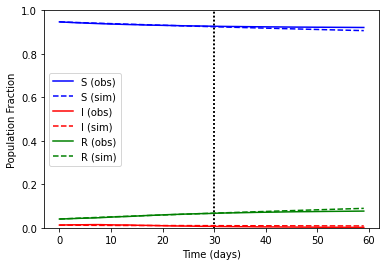

In [145]:
fig,ax=plt.subplots()
clr=["b","r","g"]

for n,var in enumerate(seir.outvar):
    ax.plot(test_data[:nt,n], label="%s (obs)" % var, color=clr[n])
    ax.plot(y_predict.detach()[:,n], label="%s (sim)" % var, 
            linestyle="dashed", color=clr[n])
    
    ax.set_ylim(0, 1.00)
    ax.vlines(nt_train, 0, 1.00, color='k', linestyle='dotted')
    ax.legend(loc='center left')
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Population Fraction")

The Figure above shows the observed (solid) against the simulated (dashed) compartment fractions.  The vertical, dotted line marks the end of the training window; values beyond 30 days are predicted from the minimum misfit model.